In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from dummy import *
from GCN_model import *
from GIN_model import *

In [4]:
dtype = torch.long
n_train = 32768
n_valid = 4096 
batch_size = 128
learning_rate = 0.0001
num_epochs = 50
n_nodes = 10
n_features = 3
hidden_dim = 10
n_classes = 4
dropout = 0.5                        

train_dataset, valid_dataset, train_features, valid_features = get_dataset(n_train, n_valid,
                                                                           n_nodes, n_classes, n_features)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)
X = torch.ones([batch_size, n_nodes, n_features])

model = TwoLayerGCN(n_features, hidden_dim, n_classes, dropout)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_log = torch.zeros((num_epochs, 4), dtype=torch.float, requires_grad=False)

correct = 0
total = 0
for epoch in range(num_epochs):
    for i, (A, labels) in enumerate(train_loader):
        
        # Forward pass
        outputs = model(X, A)
        loss = criterion(outputs.transpose(1,2), labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs,2)
        correct += (predicted == labels).sum()
        total += labels.numel()
        
    train_log[epoch, 0] = epoch
    train_log[epoch, 1] = loss.item()
    print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss))
    train_log[epoch, 2] = (100* correct / total)
    
    
with torch.no_grad():
    correct = 0
    total = 0
    for A, labels in valid_loader:
        outputs = model(X, A)
        _, predicted = torch.max(outputs, 2)
        total += labels.numel()
        correct += (predicted == labels).sum()

    print('Accuracy of the network on the test data: {} %'.format(100 * correct / total))
    
train_log = train_log.detach().numpy()

Epoch [1/50], Loss: 1.5003
Epoch [2/50], Loss: 1.2836
Epoch [3/50], Loss: 1.0278
Epoch [4/50], Loss: 0.8521
Epoch [5/50], Loss: 0.6950
Epoch [6/50], Loss: 0.5590
Epoch [7/50], Loss: 0.4345
Epoch [8/50], Loss: 0.3519
Epoch [9/50], Loss: 0.3005
Epoch [10/50], Loss: 0.2463
Epoch [11/50], Loss: 0.2140
Epoch [12/50], Loss: 0.1931
Epoch [13/50], Loss: 0.1522
Epoch [14/50], Loss: 0.1384
Epoch [15/50], Loss: 0.1144
Epoch [16/50], Loss: 0.1008
Epoch [17/50], Loss: 0.1065
Epoch [18/50], Loss: 0.0836
Epoch [19/50], Loss: 0.0676
Epoch [20/50], Loss: 0.0588
Epoch [21/50], Loss: 0.0527
Epoch [22/50], Loss: 0.0423
Epoch [23/50], Loss: 0.0926
Epoch [24/50], Loss: 0.0481
Epoch [25/50], Loss: 0.0420
Epoch [26/50], Loss: 0.0425
Epoch [27/50], Loss: 0.0199
Epoch [28/50], Loss: 0.0293
Epoch [29/50], Loss: 0.0253
Epoch [30/50], Loss: 0.0435
Epoch [31/50], Loss: 0.0296
Epoch [32/50], Loss: 0.0496
Epoch [33/50], Loss: 0.0313
Epoch [34/50], Loss: 0.0203
Epoch [35/50], Loss: 0.0270
Epoch [36/50], Loss: 0.0166
E

[Text(63.125, 0.5, 'train_acc'), Text(0.5, 69.00000000000009, 'epochs')]

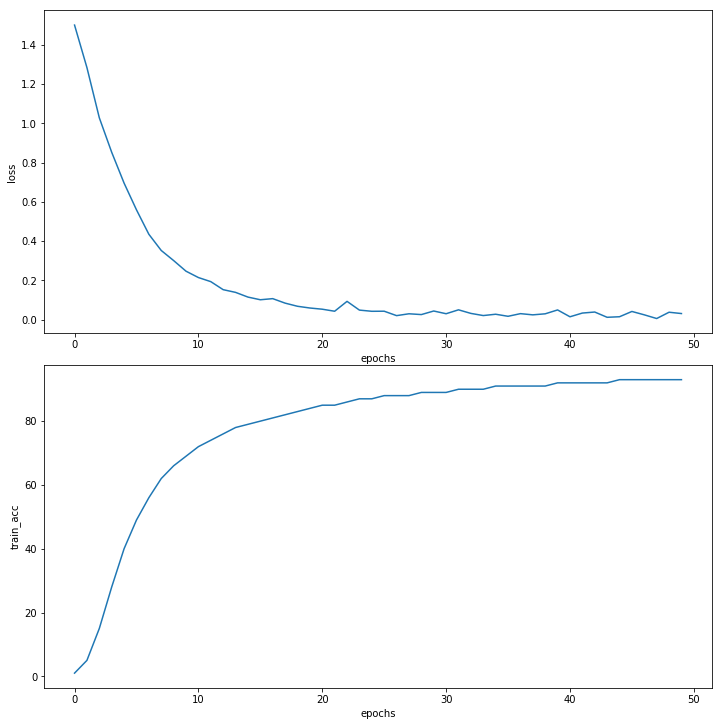

In [5]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
fig.tight_layout()

ax[0].plot(train_log[:,0], train_log[:,1])
ax[0].set(xlabel="epochs", ylabel="loss")

ax[1].plot(train_log[:,0], train_log[:,2])
ax[1].set(xlabel="epochs", ylabel="train_acc")

In [ ]:
batch_size = 128
learning_rate = 0.0001
num_epochs = 50
n_nodes = 10
n_features = 3
hidden_dim = 10
n_classes = 4
dropout = 0.5                        
n_gnn_layers = 5
n_mlp_layers = 6
learn_eps = True

model = GIN(n_gnn_layers, n_mlp_layers, n_features, hidden_dim, n_classes, learn_eps, dropout)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_log = torch.zeros((num_epochs, 4), dtype=torch.float, requires_grad=False)

correct = 0
total = 0
for epoch in range(num_epochs):
    for i, (A, labels) in enumerate(train_loader):
        
        # Forward pass
        _, outputs = model(A, X) # outputs = node scores, just like in GCN
        # TO DO: find a way to iterate over train_features_loader to pick batches of features for training 
        loss = criterion(outputs.transpose(1,2), labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs,2)
        correct += (predicted == labels).sum()
        total += labels.numel()
        
    train_log[epoch, 0] = epoch
    train_log[epoch, 1] = loss.item()
    print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss))
    train_log[epoch, 2] = (100* correct / total)
    
    
with torch.no_grad():
    correct = 0
    total = 0
    for A, labels in valid_loader:
        outputs = model(X, A)
        _, predicted = torch.max(outputs, 2)
        total += labels.numel()
        correct += (predicted == labels).sum()

    print('Accuracy of the network on the test data: {} %'.format(100 * correct / total))
    
train_log = train_log.detach().numpy()

Epoch [1/50], Loss: 0.8847
Epoch [2/50], Loss: 0.6326
Epoch [3/50], Loss: 0.5282
Epoch [4/50], Loss: 0.4935
Epoch [5/50], Loss: 0.4634
Epoch [6/50], Loss: 0.4516
Epoch [7/50], Loss: 0.4511
Epoch [8/50], Loss: 0.4363
Epoch [9/50], Loss: 0.4256
Epoch [10/50], Loss: 0.4320
Epoch [11/50], Loss: 0.4450
Epoch [12/50], Loss: 0.4200
Epoch [13/50], Loss: 0.4274
Epoch [14/50], Loss: 0.4092
Epoch [15/50], Loss: 0.4365
Epoch [16/50], Loss: 0.4360
Epoch [17/50], Loss: 0.4301
Epoch [18/50], Loss: 0.4417
Epoch [19/50], Loss: 0.4434
Epoch [20/50], Loss: 0.4127
Epoch [21/50], Loss: 0.4218
Epoch [22/50], Loss: 0.4126
Epoch [23/50], Loss: 0.4071
Epoch [24/50], Loss: 0.4053
Epoch [25/50], Loss: 0.4606
Epoch [26/50], Loss: 0.4165
Epoch [27/50], Loss: 0.4148
Epoch [28/50], Loss: 0.4210
Epoch [29/50], Loss: 0.4388
Epoch [30/50], Loss: 0.4323
Epoch [31/50], Loss: 0.4175
Epoch [32/50], Loss: 0.4087
Epoch [33/50], Loss: 0.4211
Epoch [34/50], Loss: 0.4419
Epoch [35/50], Loss: 0.4122
Epoch [36/50], Loss: 0.4231
E

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
fig.tight_layout()

ax[0].plot(train_log[:,0], train_log[:,1])
ax[0].set(xlabel="epochs", ylabel="loss")

ax[1].plot(train_log[:,0], train_log[:,2])
ax[1].set(xlabel="epochs", ylabel="train_acc")